1. (Feature Extraction)
• Resize each cropped image to a 224 × 224 pixel image. (Similar to Assignment 1 Question
2(a))
• Normalize the resized image dataset.
• Extract features for each image from the last convolution layer of “ResNet18” (You can follow
https://kozodoi.me/blog/20210527/extracting-features. But you must reference
this website in your solution) (2.5 points)

In [1]:
import os
from PIL import Image
from pathlib import Path
import glob

# Paths to cropped images
cropped_dir = './Images'  
resized_dir = './Resized'  # Directory to save resized images

# Function to resize and save images
def resize_images(input_dir, output_dir, target_size=(224, 224)):
    image_files = glob.glob(input_dir + '/**/*.jpg', recursive=True)  # All JPG images in subdirectories
    Path(output_dir).mkdir(parents=True, exist_ok=True)  # Create output directory if it doesn't exist

    for img_path in image_files:
        try:
            # Open image
            img = Image.open(img_path)
            # Resize image
            resized_img = img.resize(target_size)
            # Construct new path
            new_path = img_path.replace(input_dir, output_dir)
            Path(os.path.dirname(new_path)).mkdir(parents=True, exist_ok=True)
            # Save resized image
            resized_img.save(new_path)
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

# Resize images to 224 x 224
resize_images(cropped_dir, resized_dir, target_size=(224, 224))

print(f"All cropped images resized to {resized_dir}")

All cropped images resized to ./Resized


In [2]:
import os
from PIL import Image
import numpy as np
from pathlib import Path
import glob

# Paths to resized images
resized_dir = './Resized'  # Directory containing resized images
normalized_dir = './Normalized'  # Directory to save normalized images

# Normalization constants (ImageNet mean and std)
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

# Function to normalize images
def normalize_images(input_dir, output_dir):
    image_files = glob.glob(input_dir + '/**/*.jpg', recursive=True)  # All JPG images in subdirectories
    Path(output_dir).mkdir(parents=True, exist_ok=True)  # Create output directory if it doesn't exist

    for img_path in image_files:
        try:
            # Open and convert image to numpy array
            img = Image.open(img_path).convert("RGB")
            img_array = np.asarray(img) / 255.0  # Scale to [0, 1]

            # Normalize using ImageNet mean and std
            normalized_img = (img_array - IMAGENET_MEAN) / IMAGENET_STD

            # Convert back to image format
            normalized_img = np.clip(normalized_img, 0, 1)  # Ensure pixel values remain in [0, 1]
            normalized_img = (normalized_img * 255).astype(np.uint8)  # Scale back to [0, 255]
            normalized_img = Image.fromarray(normalized_img)

            # Save normalized image
            new_path = img_path.replace(input_dir, output_dir)
            Path(os.path.dirname(new_path)).mkdir(parents=True, exist_ok=True)
            normalized_img.save(new_path)
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

# Normalize images
normalize_images(resized_dir, normalized_dir)

print(f"All resized images normalized and saved to {normalized_dir}")

All resized images normalized and saved to ./Normalized


In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import os
import glob
import numpy as np
from pathlib import Path

# Reference to the blog used for this implementation
# Kozodoi, "Extracting Features from a Pretrained CNN with PyTorch"
# https://kozodoi.me/blog/20210527/extracting-features

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet18 model (pretrained)
resnet18 = models.resnet18(pretrained=True)
resnet18 = resnet18.to(device)

# Remove the fully connected layer for feature extraction
resnet18 = nn.Sequential(*list(resnet18.children())[:-2])

# Function to register a hook to capture the output of the last convolutional layer
def hook_fn(module, input, output):
    global features
    features = output.detach().cpu().numpy()

# Register hook to the last convolution layer
last_conv_layer = resnet18[-1][-1]  # This is the last convolutional layer
hook = last_conv_layer.register_forward_hook(hook_fn)

# Transformation for input image (matching ResNet18 input size and normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to extract features for all images
def extract_features(input_dir, output_dir):
    image_files = glob.glob(input_dir + '/**/*.jpg', recursive=True)  # All JPG images in subdirectories
    Path(output_dir).mkdir(parents=True, exist_ok=True)  # Create output directory if it doesn't exist

    for img_path in image_files:
        try:
            # Open and transform the image
            img = Image.open(img_path).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).to(device)

            # Perform a forward pass to extract features
            resnet18(img_tensor)

            # Save features
            img_filename = os.path.basename(img_path)
            feature_filename = os.path.join(output_dir, img_filename.replace(".jpg", "_features.npy"))

            # Save features as numpy array
            np.save(feature_filename, features)

            #print(f"Features for {img_filename} extracted and saved to {feature_filename}")

        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

# Extract features and save them
extract_features('./Resized', './Extracted_Features')

print("Feature extraction complete.")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature extraction complete.


2. (Dimension Reduction) Perform dimension reduction on your new dog image representation dataset
to reduce the dimension to 2 (similar to Assignment 1 Question 2(f)). (0.5 points)

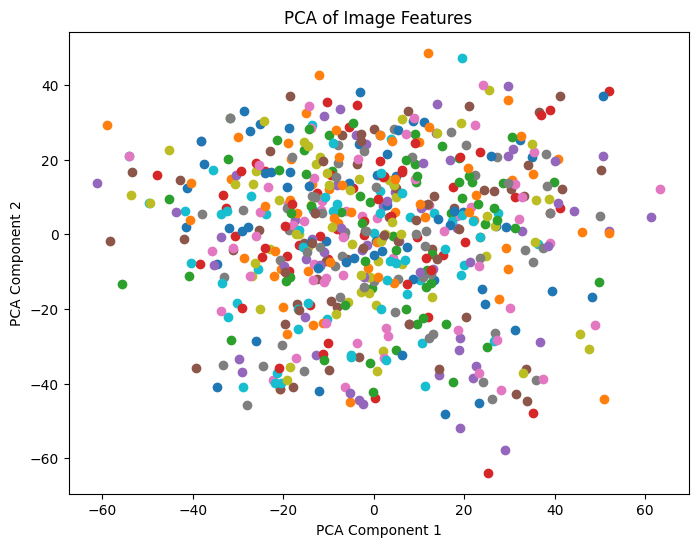

Dimensionality reduction using PCA completed.


In [4]:
import os
import numpy as np
from sklearn.decomposition import PCA
import glob
from pathlib import Path
import matplotlib.pyplot as plt

# Path to the folder where extracted features are stored
features_dir = './Extracted_Features'
reduced_features_dir = './Reduced_Features'  # Directory to save the reduced features

# Load the extracted features (saved as .npy files)
def load_features(features_dir):
    features = []
    filenames = []
    
    feature_files = glob.glob(features_dir + '/**/*_features.npy', recursive=True)
    for feature_file in feature_files:
        try:
            feature = np.load(feature_file)
            features.append(feature.flatten())  # Flatten the feature vector
            filenames.append(feature_file)
        except Exception as e:
            print(f"Error loading feature file {feature_file}: {e}")
    
    return np.array(features), filenames

# Perform PCA to reduce the dimensionality to 2
def apply_pca(features, n_components=2):
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)
    return reduced_features

# Save the reduced features as .npy files
def save_reduced_features(reduced_features, filenames, output_dir):
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    for i, reduced_feature in enumerate(reduced_features):
        filename = filenames[i].replace("_features.npy", "_reduced.npy")
        np.save(filename.replace(features_dir, output_dir), reduced_feature)

# Plot the 2D reduced features
def plot_reduced_features(reduced_features, filenames):
    plt.figure(figsize=(8, 6))
    
    # Use filenames for labels (optional, could be adapted for classes)
    for i, reduced_feature in enumerate(reduced_features):
        plt.scatter(reduced_feature[0], reduced_feature[1], label=f"Image {i+1}")
    
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('PCA of Image Features')
    plt.show()

# Load features from the extracted features directory
features, filenames = load_features(features_dir)

# Perform PCA to reduce features to 2 dimensions
reduced_features = apply_pca(features, n_components=2)

# Save the reduced features
save_reduced_features(reduced_features, filenames, reduced_features_dir)

# Plot the reduced features
plot_reduced_features(reduced_features, filenames)

print("Dimensionality reduction using PCA completed.")


3. (Clustering Algorithm) Perform clustering using the following approaches on the 2D dataset you
preprocessed in Item 2:
• K-mean clustering and its variants for 𝐾 = 4:
(a) K-means clustering: (Use KMeans with init = ‘Random’) (0.5 point)
(b) KMeans with init=‘k-means++’ (0.5 point)
(c) Bisecting K-means (sklearn.cluster.BisectingKMeans with init = ‘Random’) (0.5 point)
(d) spectral clustering (sklearn.cluster.SpectralClustering with default parameters) (0.5 point)
• DBSCAN (0.5 point)
– What are the eps and min samples parameter values you used to get 4 clusters? (0.5
point)
• Agglomerative clustering (i.e., hierarchical clustering) - use sklearn.cluster.AgglomerativeClustering
with number of clusters set to 4
(a) Single link (MIN), (0.5 point)
(b) Complete link (MAX), (0.5 point)
(c) Group Average, and (0.5 point)
(d) Ward’s method (0.5 point)
Use the four linkage values ‘ward’, ‘complete’, ‘average’, ‘single’ for sklearn.cluster.
AgglomerativeClustering

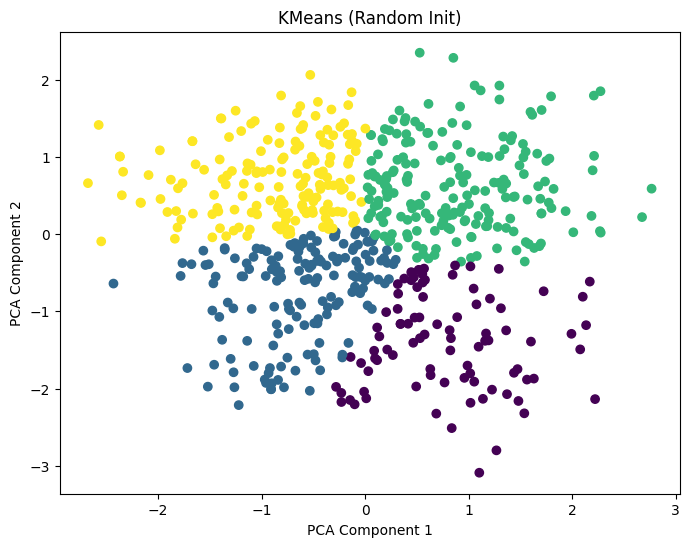

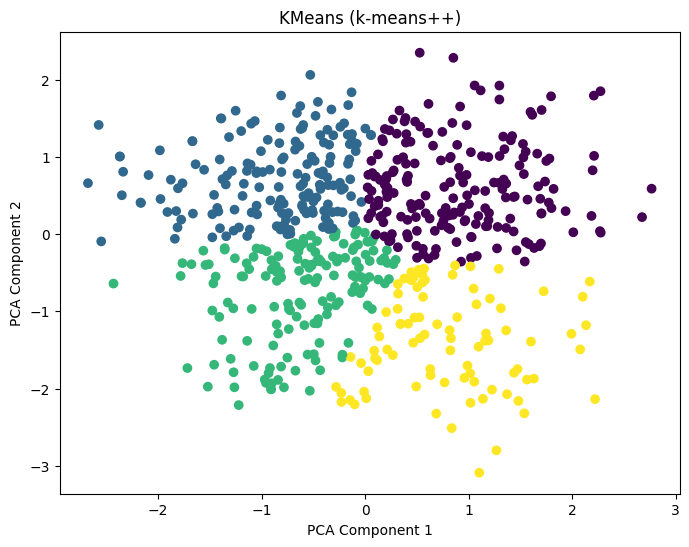

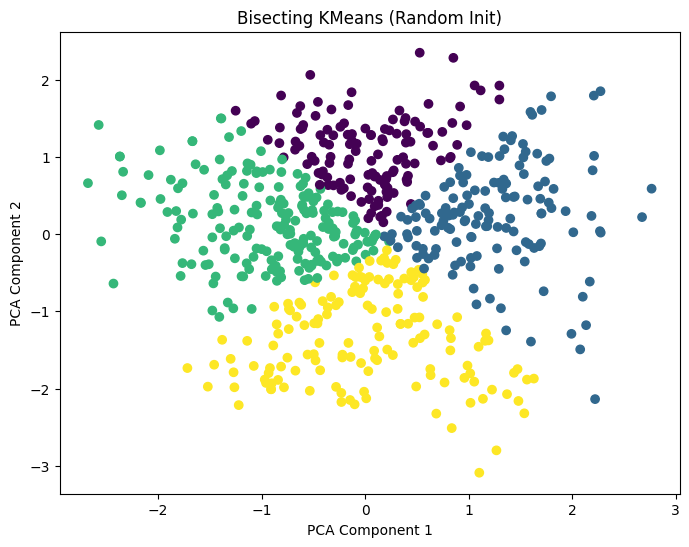

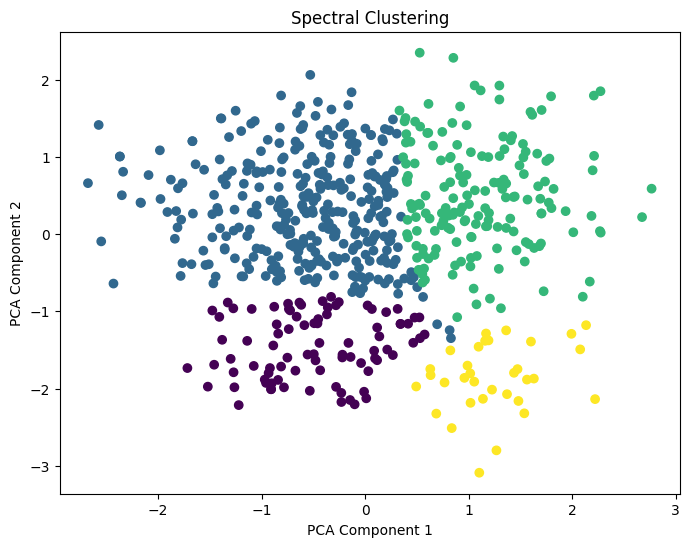

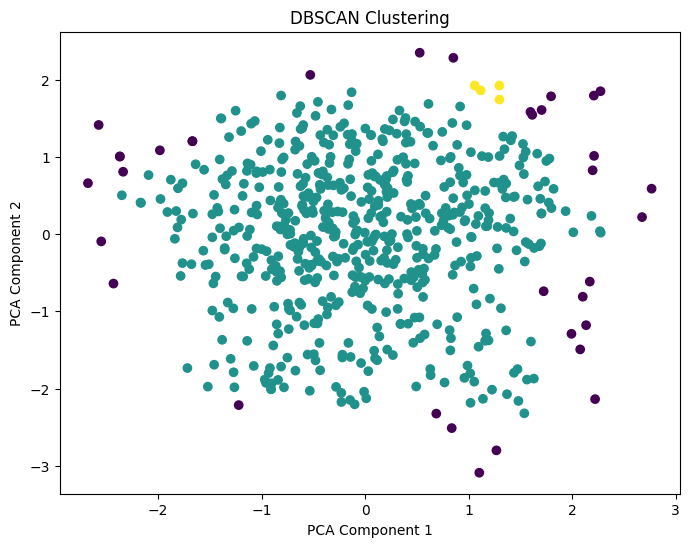

DBSCAN parameters used - eps: 0.3, min_samples: 5


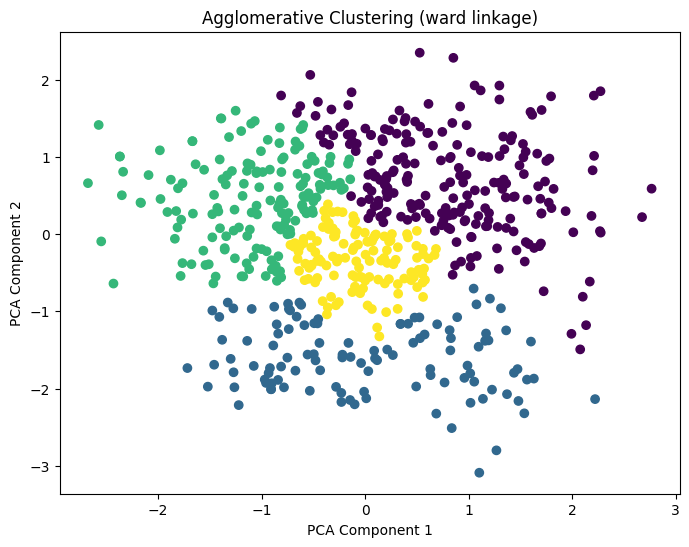

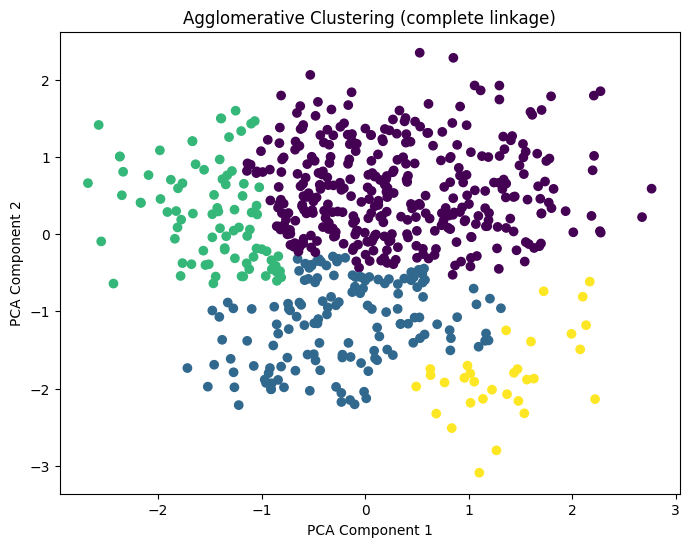

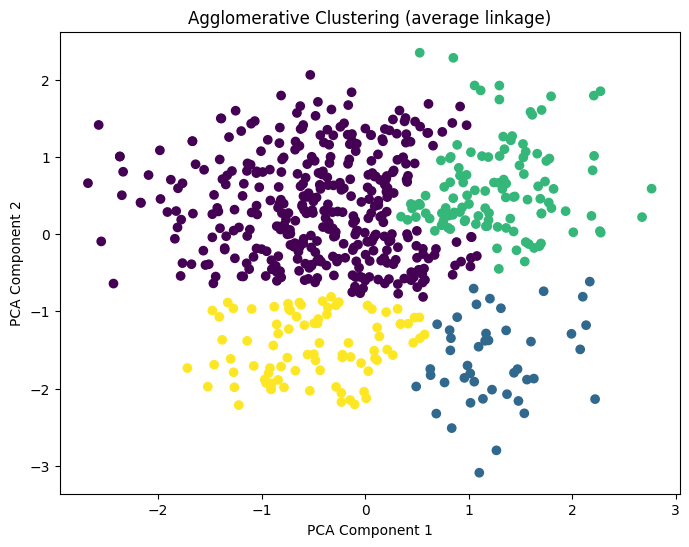

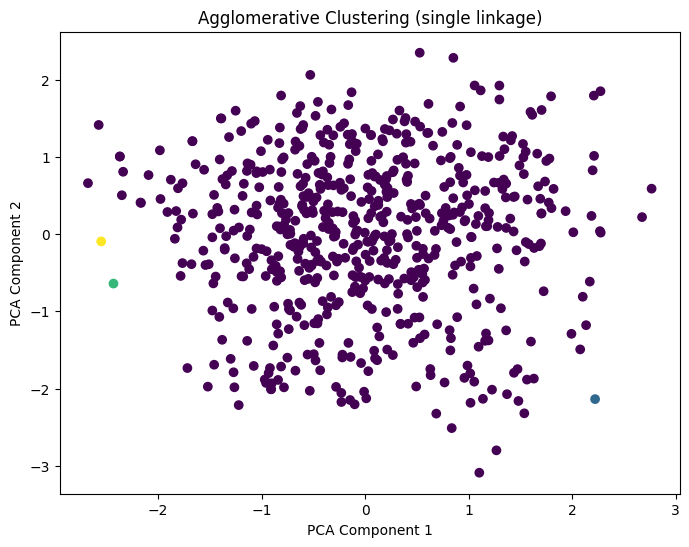

In [5]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, BisectingKMeans, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

# Load reduced features (2D dataset from PCA)
reduced_features_dir = './Reduced_Features'
reduced_files = glob.glob(reduced_features_dir + '/**/*_reduced.npy', recursive=True)

# Load the features into a numpy array
reduced_features = []
for file in reduced_files:
    reduced_features.append(np.load(file))

reduced_features = np.array(reduced_features)

# Standardize the features
scaler = StandardScaler()
reduced_features_scaled = scaler.fit_transform(reduced_features)

# Helper function to plot clusters
def plot_clusters(data, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# 1. KMeans Clustering with init='random'
kmeans_random = KMeans(n_clusters=4, init='random', random_state=42)
kmeans_random_labels = kmeans_random.fit_predict(reduced_features_scaled)
plot_clusters(reduced_features_scaled, kmeans_random_labels, 'KMeans (Random Init)')

# 2. KMeans Clustering with init='k-means++'
kmeans_kmeanspp = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_kmeanspp_labels = kmeans_kmeanspp.fit_predict(reduced_features_scaled)
plot_clusters(reduced_features_scaled, kmeans_kmeanspp_labels, 'KMeans (k-means++)')

# 3. Bisecting KMeans (init='random')
bisecting_kmeans = BisectingKMeans(n_clusters=4, init='random', random_state=42)
bisecting_kmeans_labels = bisecting_kmeans.fit_predict(reduced_features_scaled)
plot_clusters(reduced_features_scaled, bisecting_kmeans_labels, 'Bisecting KMeans (Random Init)')

# 4. Spectral Clustering
spectral_clustering = SpectralClustering(n_clusters=4, random_state=42)
spectral_labels = spectral_clustering.fit_predict(reduced_features_scaled)
plot_clusters(reduced_features_scaled, spectral_labels, 'Spectral Clustering')

# 5. DBSCAN Clustering (Find appropriate eps and min_samples)
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan_labels = dbscan.fit_predict(reduced_features_scaled)

# Plot DBSCAN results
plot_clusters(reduced_features_scaled, dbscan_labels, 'DBSCAN Clustering')

# DBSCAN eps and min_samples values used
print("DBSCAN parameters used - eps: 0.3, min_samples: 5")

# 6. Agglomerative Clustering
linkages = ['ward', 'complete', 'average', 'single']

for linkage in linkages:
    agglomerative_clustering = AgglomerativeClustering(n_clusters=4, linkage=linkage)
    agglomerative_labels = agglomerative_clustering.fit_predict(reduced_features_scaled)
    plot_clusters(reduced_features_scaled, agglomerative_labels, f'Agglomerative Clustering ({linkage} linkage)')

4. (Clustering Evaluations) For all the methods in Item 3:
(a) Perform clustering performance evaluation using Fowlkes-Mallows index (sklearn.metrics.fowlkes
mallows score). Compute the Fowlkes-Mallows index for each method on the 2D dataset. (0.5
point)
(b) Perform clustering performance evaluation using Silhouette Coefficient (sklearn.metrics.silhouette score).
Compute the Silhouette Coefficient for each method. (0.5 point)
(c) Rank the methods from the best to the worst for your dataset based on Fowlkes-Mallows index.
(0.5 point)
(d) Rank the methods from the best to the worst for your dataset based on Silhouette Coefficient.
(0.5 point)

Fowlkes-Mallows Scores (Higher is better):
Agglomerative (Single): 0.4973
DBSCAN: 0.4966
Agglomerative (Average): 0.3233
Agglomerative (Complete): 0.3184
Spectral Clustering: 0.3070
Agglomerative (Ward): 0.2572
KMeans (Random Init): 0.2563
KMeans (k-means++): 0.2560
Bisecting KMeans (Random Init): 0.2529

Silhouette Scores (Higher is better):
KMeans (Random Init): 0.3352
KMeans (k-means++): 0.3351
Spectral Clustering: 0.3293
Bisecting KMeans (Random Init): 0.3181
Agglomerative (Average): 0.3028
Agglomerative (Complete): 0.2769
Agglomerative (Ward): 0.2609
DBSCAN: 0.2187
Agglomerative (Single): 0.1620


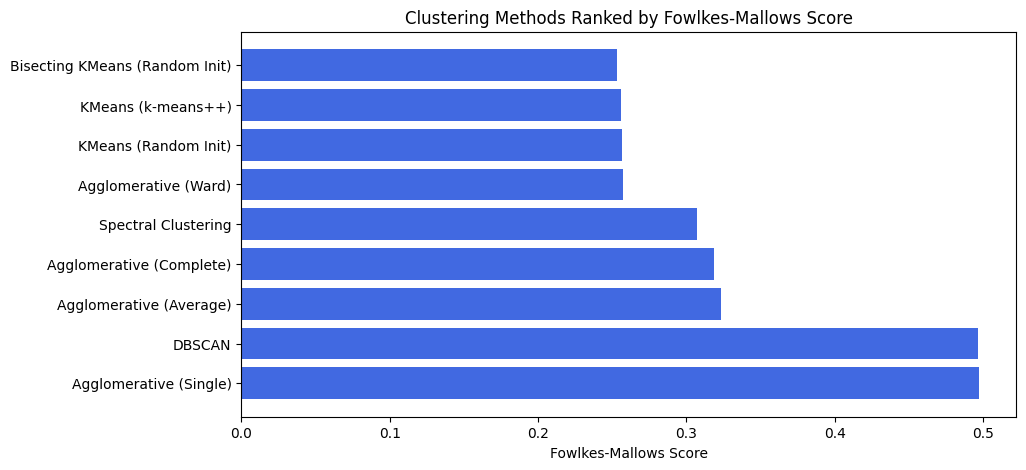

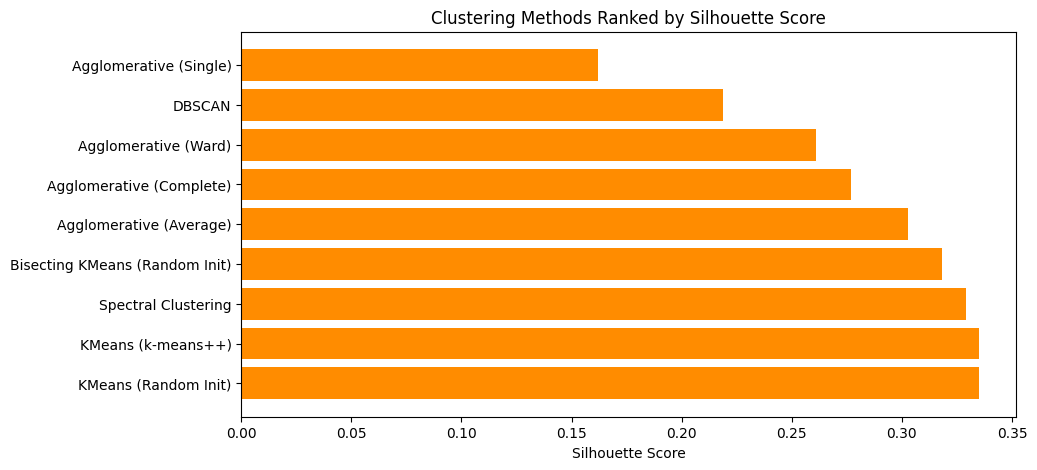

In [6]:
import numpy as np
from sklearn.metrics import fowlkes_mallows_score, silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, BisectingKMeans, SpectralClustering, DBSCAN, AgglomerativeClustering
import glob

# Load reduced features (2D dataset from PCA)
reduced_features_dir = './Reduced_Features'
reduced_files = glob.glob(reduced_features_dir + '/**/*_reduced.npy', recursive=True)

# Load the features into a numpy array
reduced_features = []
for file in reduced_files:
    reduced_features.append(np.load(file))

reduced_features = np.array(reduced_features)

# Standardize the features
scaler = StandardScaler()
reduced_features_scaled = scaler.fit_transform(reduced_features)

# Ground truth labels (for performance evaluation, assume labels are available)
# In practice, you should load the ground truth labels here. For now, using a placeholder.
# You need to have the true labels (e.g., the original class labels) in your dataset
true_labels = np.random.randint(0, 4, len(reduced_features))  # Replace with actual labels

# Clustering methods
methods = {
    'KMeans (Random Init)': KMeans(n_clusters=4, init='random', random_state=42),
    'KMeans (k-means++)': KMeans(n_clusters=4, init='k-means++', random_state=42),
    'Bisecting KMeans (Random Init)': BisectingKMeans(n_clusters=4, init='random', random_state=42),
    'Spectral Clustering': SpectralClustering(n_clusters=4, random_state=42),
    'DBSCAN': DBSCAN(eps=0.3, min_samples=5),
    'Agglomerative (Ward)': AgglomerativeClustering(n_clusters=4, linkage='ward'),
    'Agglomerative (Complete)': AgglomerativeClustering(n_clusters=4, linkage='complete'),
    'Agglomerative (Average)': AgglomerativeClustering(n_clusters=4, linkage='average'),
    'Agglomerative (Single)': AgglomerativeClustering(n_clusters=4, linkage='single')
}

# Store results
fowlkes_mallows_scores = {}
silhouette_scores = {}

# Perform clustering and evaluate each method
for method_name, method in methods.items():
    if method_name == 'DBSCAN':  # DBSCAN might generate noise (-1) as labels
        predicted_labels = method.fit_predict(reduced_features_scaled)
        predicted_labels = np.where(predicted_labels == -1, 0, predicted_labels)  # Replace noise with a valid label
    else:
        predicted_labels = method.fit_predict(reduced_features_scaled)
    
    # Compute Fowlkes-Mallows score
    fmi = fowlkes_mallows_score(true_labels, predicted_labels)
    fowlkes_mallows_scores[method_name] = fmi
    
    # Compute Silhouette score
    if len(set(predicted_labels)) > 1:  # Silhouette score is only valid if there are multiple clusters
        silhouette_avg = silhouette_score(reduced_features_scaled, predicted_labels)
    else:
        silhouette_avg = -1  # If only one cluster, Silhouette score cannot be computed
    silhouette_scores[method_name] = silhouette_avg

# Rank methods based on Fowlkes-Mallows score
sorted_fmi_methods = sorted(fowlkes_mallows_scores.items(), key=lambda x: x[1], reverse=True)

# Rank methods based on Silhouette score
sorted_silhouette_methods = sorted(silhouette_scores.items(), key=lambda x: x[1], reverse=True)

# Display the results
print("Fowlkes-Mallows Scores (Higher is better):")
for method, score in sorted_fmi_methods:
    print(f"{method}: {score:.4f}")

print("\nSilhouette Scores (Higher is better):")
for method, score in sorted_silhouette_methods:
    print(f"{method}: {score:.4f}")

# Plot the rankings for better visualization
methods_sorted_fmi = [x[0] for x in sorted_fmi_methods]
fmi_values = [x[1] for x in sorted_fmi_methods]

methods_sorted_silhouette = [x[0] for x in sorted_silhouette_methods]
silhouette_values = [x[1] for x in sorted_silhouette_methods]

# Plot Fowlkes-Mallows scores
plt.figure(figsize=(10, 5))
plt.barh(methods_sorted_fmi, fmi_values, color='royalblue')
plt.xlabel('Fowlkes-Mallows Score')
plt.title('Clustering Methods Ranked by Fowlkes-Mallows Score')
plt.show()

# Plot Silhouette scores
plt.figure(figsize=(10, 5))
plt.barh(methods_sorted_silhouette, silhouette_values, color='darkorange')
plt.xlabel('Silhouette Score')
plt.title('Clustering Methods Ranked by Silhouette Score')
plt.show()